In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cma
import foolbox as fb
from foolbox.attacks import BoundaryAttack
from foolbox.criteria import Misclassification
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
# ========== 載入模型與圖片 ==========
model = YOLO(r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt").to('cuda')

img = cv2.imread(image_path)
img = cv2.resize(img, (640, 640)).astype(np.float32) / 255.0
img_tensor = torch.tensor(img.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
orig_img = cv2.imread(image_path)
orig_img = cv2.resize(orig_img, (640, 640)).astype(np.float32) / 255.0


# ========== YOLO 評分函數 ==========
def get_yolo_score(img_np):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    return float(boxes.conf.max().item())








In [ ]:
'''import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 載入模型與圖片 ==========
model = YOLO(r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train6\weights\best.pt").to('cuda')
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg"

img = cv2.imread(image_path)
img = cv2.resize(img, (640, 640)).astype(np.float32) / 255.0
orig_img = img.copy()

# ========== YOLO 評分函數 ==========
def get_yolo_score(img_np, target_class=None):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    if target_class is not None:
        cls_scores = boxes.cls
        confs = boxes.conf
        target_scores = confs[cls_scores == target_class]
        return float(target_scores.max().item()) if len(target_scores) > 0 else 0.0
    return float(boxes.conf.max().item())
results = model(img_tensor)
boxes = results[0].boxes
for box in boxes:
    cls = int(box.cls.item())
    conf = float(box.conf.item())
    print(f"類別：{cls}, 信心：{conf:.2f}")
# ========== NES 攻擊 ==========
def nes_attack(img, model, epsilon=0.05, iterations=100, sigma=0.1, target_class=None):
    img_shape = img.shape
    perturbed_img = img.copy()
    best_score = get_yolo_score(perturbed_img, target_class)

    scores = [best_score]  # 儲存每次的信心分數

    for i in range(iterations):
        grads = np.zeros_like(img)
        for _ in range(20):
            noise = np.random.normal(size=img_shape).astype(np.float32)
            pos_img = np.clip(perturbed_img + sigma * noise, 0, 1)
            neg_img = np.clip(perturbed_img - sigma * noise, 0, 1)
            score_pos = get_yolo_score(pos_img, target_class)
            score_neg = get_yolo_score(neg_img, target_class)
            grads += (score_pos - score_neg) * noise

        grads /= 20
        perturbed_img = perturbed_img - epsilon * grads
        perturbed_img = np.clip(perturbed_img, 0, 1)

        new_score = get_yolo_score(perturbed_img, target_class)
        scores.append(new_score)
        print(f"[NES] Iter {i+1:03d} - Conf: {new_score:.4f}")

        if new_score < 0.1:
            print("[NES] 攻擊成功，模型信心大幅下降！")
            break

    # 顯示信心分數變化圖
    plt.figure()
    plt.plot(scores, marker='o')
    plt.title("信心分數下降過程 (NES 攻擊)")
    plt.xlabel("迭代次數")
    plt.ylabel("信心分數")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return perturbed_img


# ========== 執行攻擊 ==========
target_class_index = 9  # 例如：Speed Limit 20
perturbed = nes_attack(orig_img, model, epsilon=0.1, iterations=1000, sigma=0.1, target_class=target_class_index)

# ========== 對抗圖像上重新預測 ==========
pred = model(torch.tensor(perturbed.transpose(2, 0, 1)).unsqueeze(0).float().to('cuda'))[0].plot()

# ========== 顯示結果 ==========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("原圖")
plt.imshow(orig_img[:, :, ::-1])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("對抗圖 + 偵測")
plt.imshow(pred)
plt.axis('off')

plt.tight_layout()
plt.show()'''


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import cma

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 模型與圖片載入 ==========
model = YOLO(r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt").to('cuda')
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg"

img = cv2.imread(image_path)
img = cv2.resize(img, (640, 640)).astype(np.float32) / 255.0
orig_img = img.copy()

results = model(img_tensor)
boxes = results[0].boxes
for box in boxes:
    cls = int(box.cls.item())
    conf = float(box.conf.item())
    print(f"類別：{cls}, 信心：{conf:.2f}")
# ========== 信心分數取得 ==========
def get_yolo_score(img_np, target_class=None):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    if target_class is not None:
        cls_scores = boxes.cls
        confs = boxes.conf
        target_scores = confs[cls_scores == target_class]
        return float(target_scores.max().item()) if len(target_scores) > 0 else 0.0
    return float(boxes.conf.max().item())
   
# ========== NES 攻擊 ==========

# ========== CMA-ES 攻擊實作 ==========
def cmaes_patch_attack(image, patch_size=64, max_iter=100, epsilon=0.3, target_class=None):
    h, w, _ = image.shape
    img = image.copy()
    top = np.random.randint(0, h - patch_size)
    left = np.random.randint(0, w - patch_size)

    init_patch = np.zeros((patch_size * patch_size * 3), dtype=np.float32)
    scores_over_time = []

    def evaluate(patch_flat):
        patch = patch_flat.reshape((patch_size, patch_size, 3))
        patch = np.clip(patch, -epsilon, epsilon)
        adv_img = img.copy()
        adv_img[top:top+patch_size, left:left+patch_size] += patch
        adv_img = np.clip(adv_img, 0, 1)
        score = get_yolo_score(adv_img, target_class)
        scores_over_time.append(score)
        return score

    es = cma.CMAEvolutionStrategy(init_patch, 0.1, {'maxiter': max_iter})
    for _ in range(max_iter):
        solutions = es.ask()
        scores = [evaluate(x) for x in solutions]
        es.tell(solutions, scores)
        es.logger.add()
        es.disp()

    best_patch = es.best.x.reshape((patch_size, patch_size, 3))
    best_patch = np.clip(best_patch, -epsilon, epsilon)
    adv_img = img.copy()
    adv_img[top:top+patch_size, left:left+patch_size] += best_patch
    adv_img = np.clip(adv_img, 0, 1)

    return adv_img, (top, left, patch_size), scores_over_time

# ========== 視覺化：原圖 + 對抗圖 + Patch框 ==========
def visualize_result(orig, adv, patch_info):
    top, left, patch_size = patch_info

    plt.figure(figsize=(12, 5))

    # 原圖
    plt.subplot(1, 2, 1)
    plt.title("原圖")
    plt.imshow(orig[:, :, ::-1])
    plt.axis('off')

    # 對抗圖 + YOLO 偵測 + Patch 框框
    plt.subplot(1, 2, 2)
    plt.title("對抗圖 + 偵測 + Patch")
    results = model(torch.tensor(adv.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda'))
    result_img = results[0].plot()[..., ::-1]
    plt.imshow(result_img)
    ax = plt.gca()
    rect = patches.Rectangle((left, top), patch_size, patch_size,
                             linewidth=2, edgecolor='blue', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ========== 顯示信心分數下降過程 ==========
def plot_score_trend(scores):
    plt.figure()
    plt.plot(scores, marker='o')
    plt.title("信心分數下降過程 (CMA-ES 攻擊)")
    plt.xlabel("進化次數")
    plt.ylabel("信心分數")
    plt.grid(True)
    plt.show()

# ========== 執行攻擊 ==========
target_class_index = 9  # 攻擊 Speed Limit 20
adv_img, patch_info, score_trend = cmaes_patch_attack(orig_img, patch_size=40, max_iter=60, epsilon=0.25, target_class=target_class_index)

# ========== 顯示攻擊結果 ==========
visualize_result(orig_img, adv_img, patch_info)
plot_score_trend(score_trend)


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cma

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 參數設定 ==========
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg"
model_path = r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt"
patch_size = 64  # Patch 大小 (32x32)
max_iter = 1000   # CMA-ES 最大迭代
epsilon = 0.7    # 擾動強度

# ========== 載入圖片與模型 ==========
model = YOLO(model_path).to('cuda')
orig_img = cv2.imread(image_path)
orig_img = cv2.resize(orig_img, (640, 640)).astype(np.float32) / 255.0

# 取得原始圖片偵測信心值
def get_yolo_score(img_np):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    return float(boxes.conf.max().item())

original_score = get_yolo_score(orig_img)
print(f"原始圖片信心值: {original_score:.4f}")

# ========== CMA-ES Patch 攻擊 ==========
def cmaes_patch_attack(image, patch_size=32, max_iter=100, epsilon=0.2):
    h, w, _ = image.shape
    img = image.copy()

    # 隨機選一個位置放 patch
    top = np.random.randint(0, h - patch_size)
    left = np.random.randint(0, w - patch_size)

    # 初始 patch 值
    init_patch = np.zeros((patch_size * patch_size * 3), dtype=np.float32)

    # 評分函數：對抗目標是讓信心值「越小越好」
    def evaluate(patch_flat):
        patch = patch_flat.reshape((patch_size, patch_size, 3))
        patch = np.clip(patch, -epsilon, epsilon)  # 控制擾動大小

        adv_img = img.copy()
        adv_img[top:top+patch_size, left:left+patch_size] += patch
        adv_img = np.clip(adv_img, 0, 1)

        score = get_yolo_score(adv_img)
        return score

    # CMA-ES 優化
    es = cma.CMAEvolutionStrategy(init_patch, 0.1, {'maxiter': max_iter})
    while not es.stop():
        solutions = es.ask()
        scores = [evaluate(np.array(x)) for x in solutions]
        es.tell(solutions, scores)
        es.disp()

    # 套用最佳 patch
    best_patch = es.best.x.reshape((patch_size, patch_size, 3))
    best_patch = np.clip(best_patch, -epsilon, epsilon)
    adv_img = img.copy()
    adv_img[top:top+patch_size, left:left+patch_size] += best_patch
    adv_img = np.clip(adv_img, 0, 1)

    return adv_img, (top, left, patch_size)

# ========== 執行攻擊 ==========
adv_img, (t, l, s) = cmaes_patch_attack(orig_img, patch_size, max_iter, epsilon)
adv_score = get_yolo_score(adv_img)
print(f"對抗圖片信心值: {adv_score:.4f}")

# ========== 顯示圖片 ==========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"原始圖\n信心值: {original_score:.3f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"CMA-ES 對抗圖\n信心值: {adv_score:.3f}")
plt.axis('off')
# ========== 儲存圖片 ==========
# 對抗圖片
adv_img_uint8 = (adv_img * 255).astype(np.uint8)
cv2.imwrite("cmaes_adv_result.png", cv2.cvtColor(adv_img_uint8, cv2.COLOR_RGB2BGR))

# Patch 圖
#patch_img = (best_patch + epsilon) / (2 * epsilon)  # 正規化成 [0, 1]
#cv2.imwrite("patch.png", (patch_img * 255).astype(np.uint8))

# 差異圖
diff_img = np.abs(orig_img - adv_img)
cv2.imwrite("diff.png", (diff_img * 255).astype(np.uint8))


# 標記 patch 位置
#rect = plt.Rectangle((l, t), s, s, edgecolor='red', facecolor='none', linewidth=2)
#plt.gca().add_patch(rect)

#plt.tight_layout()
#plt.show()
# ========== 畫出信心值下降歷程 ==========
plt.figure(figsize=(8, 4))
plt.plot(cmaes_patch_attack, label="YOLO 信心值")
plt.xlabel("Iteration")
plt.ylabel("Confidence")
plt.title("CMA-ES 攻擊過程中的信心值變化")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("score_plot.png")
plt.show()



In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cma

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 參數設定 ==========
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg"
model_path = r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt"
patch_size = 64   # Patch 大小
max_iter = 1000   # CMA-ES 最大迭代
epsilon = 0.7     # 擾動強度

# ========== 載入圖片與模型 ==========
model = YOLO(model_path).to('cuda')
orig_img = cv2.imread(image_path)
orig_img = cv2.resize(orig_img, (640, 640)).astype(np.float32) / 255.0

# ========== 取得原始圖片信心值 ==========
def get_yolo_score(img_np):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    return float(boxes.conf.max().item())

original_score = get_yolo_score(orig_img)
print(f"原始圖片信心值: {original_score:.4f}")

# ========== CMA-ES Patch 攻擊 ==========
def cmaes_patch_attack(image, patch_size=32, max_iter=100, epsilon=0.2):
    h, w, _ = image.shape
    img = image.copy()

    # 隨機選一個位置放 patch
    top = np.random.randint(0, h - patch_size)
    left = np.random.randint(0, w - patch_size)

    # 初始 patch 值
    init_patch = np.zeros((patch_size * patch_size * 3), dtype=np.float32)
    confidence_history = []

    def evaluate(patch_flat):
        patch = patch_flat.reshape((patch_size, patch_size, 3))
        patch = np.clip(patch, -epsilon, epsilon)

        adv_img = img.copy()
        adv_img[top:top+patch_size, left:left+patch_size] += patch
        adv_img = np.clip(adv_img, 0, 1)

        score = get_yolo_score(adv_img)
        return score

    es = cma.CMAEvolutionStrategy(init_patch, 0.1, {'maxiter': max_iter})
    while not es.stop():
        solutions = es.ask()
        scores = [evaluate(np.array(x)) for x in solutions]
        es.tell(solutions, scores)

        best_score = min(scores)
        confidence_history.append(best_score)
        print(f"[Iteration {len(confidence_history)}] 最佳信心值: {best_score:.4f}")

        es.disp()

    best_patch = es.best.x.reshape((patch_size, patch_size, 3))
    best_patch = np.clip(best_patch, -epsilon, epsilon)

    adv_img = img.copy()
    adv_img[top:top+patch_size, left:left+patch_size] += best_patch
    adv_img = np.clip(adv_img, 0, 1)

    return adv_img, (top, left, patch_size), best_patch, confidence_history

# ========== 執行攻擊 ==========
adv_img, (t, l, s), best_patch, confidence_history = cmaes_patch_attack(
    orig_img, patch_size, max_iter, epsilon
)
adv_score = get_yolo_score(adv_img)
print(f"最終對抗圖片信心值: {adv_score:.4f}")

# ========== 顯示圖片 ==========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"原始圖\n信心值: {original_score:.3f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"CMA-ES 對抗圖\n信心值: {adv_score:.3f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# ========== 儲存圖片 ==========
adv_img_uint8 = (adv_img * 255).astype(np.uint8)
cv2.imwrite("cmaes_adv_result1.png", cv2.cvtColor(adv_img_uint8, cv2.COLOR_RGB2BGR))

# Patch 圖
patch_img = (best_patch + epsilon) / (2 * epsilon)  # Normalize to [0, 1]
cv2.imwrite("patch.png", (patch_img * 255).astype(np.uint8))

# 差異圖
diff_img = np.abs(orig_img - adv_img)
cv2.imwrite("diff.png", (diff_img * 255).astype(np.uint8))

# ========== 畫出信心值下降歷程 ==========
plt.figure(figsize=(8, 4))
plt.plot(confidence_history, label="YOLO 信心值")
plt.xlabel("Iteration")
plt.ylabel("Confidence")
plt.title("CMA-ES 攻擊過程中的信心值變化")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("score_plot.png")
plt.show()


In [ ]:
'''def boundary_attack(img, label=1, steps=80):
    # 定義 YOLO 的 wrapper，把偵測轉成二分類 (有偵測 / 沒偵測)
    class Wrapper(torch.nn.Module):
        def forward(self, x):
            results = model(x)
            out = torch.zeros(x.shape[0], 2).to(x.device)
            for i, res in enumerate(results):
                out[i, 0] = 1.0 if len(res.boxes) > 0 else 0.0  # 有偵測
                out[i, 1] = 1.0 - out[i, 0]                      # 沒偵測
            return out

    # 包裝模型
    fmodel = fb.PyTorchModel(Wrapper().eval(), bounds=(0, 1))

    # 建立起始點：原圖加一點雜訊（確保最初是錯誤分類）
    start_img = np.clip(img + np.random.uniform(-0.1, 0.1, img.shape), 0, 1)

    # 轉換成 tensor 格式
    input_tensor = torch.tensor(img.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    start_tensor = torch.tensor(start_img.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')

    # 定義攻擊目標：原本是有偵測（class 1），希望讓它變成沒有偵測
    criterion = Misclassification(torch.tensor([label]).to('cuda'))

    # 執行攻擊
    attack = BoundaryAttack()
    raw_adv = attack(fmodel, input_tensor, criterion=criterion, epsilons=0.5)

    # 將結果轉成 numpy 圖片
    adv = raw_adv.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    return adv
'''

d:\anaconda\Lib\site-packages\ultralytics\nn\tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")



0: 640x640 1 Speed Limit 30, 1 Speed Limit 80, 108.1ms
Speed: 0.0ms preprocess, 108.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)
原始圖片信心值: 0.7046

0: 640x640 1 Speed Limit 30, 1 Speed Limit 80, 64.0ms
Speed: 0.0ms preprocess, 64.0ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 12288 (seed=864881, Wed Mar 12 12:59:05 2025)

0: 640x640 1 Speed Limit 30, 1 Speed Limit 80, 29.9ms
Speed: 0.0ms preprocess, 29.9ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 1 Speed Limit 80, 31.3ms
Speed: 0.0ms preprocess, 31.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 1 Speed Limit 50, 25.7ms
Speed: 0.0ms preprocess, 25.7ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 27.3ms
Speed: 0.0ms preprocess, 27.3ms inference, 2.0ms postprocess per image at shape (1, 3, 64

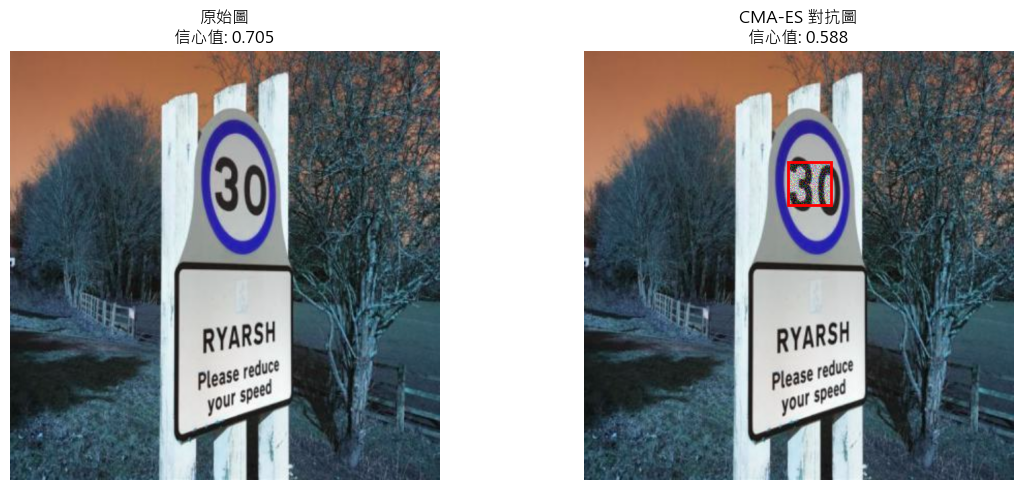

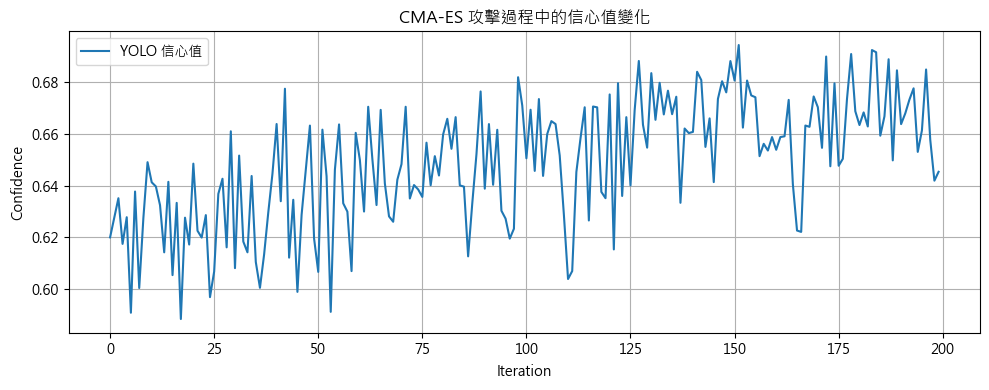

In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cma

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 中文字體

# ========== 參數設定 ==========
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg"
model_path = r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt"
patch_size = 64
max_iter = 10
epsilon = 0.7
popsize = 20
target_cls = None
early_stop_threshold = 0.2  # 提早停止的信心值門檻

# ========== 載入圖片與模型 ==========
model = YOLO(model_path).to('cuda')
orig_img = cv2.imread(image_path)
orig_img = cv2.resize(orig_img, (640, 640)).astype(np.float32) / 255.0

def get_yolo_score(img_np):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    if target_cls is not None:
        boxes = boxes[boxes.cls == target_cls]
        if len(boxes) == 0:
            return 0.0
    return float(boxes.conf.max().item())

original_score = get_yolo_score(orig_img)
print(f"原始圖片信心值: {original_score:.4f}")

# ========== CMA-ES 攻擊實作 ==========
def cmaes_patch_attack_v2(image, model, patch_size=64, max_iter=100, epsilon=0.7, target_cls=None, popsize=20, stop_score=0.2):
    h, w, _ = image.shape
    img = image.copy()

    x_tensor = torch.tensor(img.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        print("⚠️ 未偵測到任何框，改為隨機位置放置 patch")
        top = np.random.randint(0, h - patch_size)
        left = np.random.randint(0, w - patch_size)
    else:
        target_boxes = boxes[boxes.cls == target_cls] if target_cls is not None else boxes
        if len(target_boxes) == 0:
            target_boxes = boxes
        box = target_boxes[torch.argmax(target_boxes.conf)]
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        top = max(0, min(h - patch_size, cy - patch_size // 2))
        left = max(0, min(w - patch_size, cx - patch_size // 2))

    init_patch = np.zeros((patch_size * patch_size * 3), dtype=np.float32)
    best_patch_holder = [None]
    score_history = []

    def evaluate(patch_flat):
        patch = patch_flat.reshape((patch_size, patch_size, 3))
        patch = np.clip(patch, -epsilon, epsilon)

        adv_img = img.copy()
        adv_img[top:top+patch_size, left:left+patch_size] += patch
        adv_img = np.clip(adv_img, 0, 1)

        score = get_yolo_score(adv_img)
        score_history.append(score)

        # 更新最佳 patch
        if len(score_history) == 1 or score < min(score_history[:-1]):
            best_patch_holder[0] = patch.copy()

        return -score

    es = cma.CMAEvolutionStrategy(init_patch, 0.2, {
        'maxiter': max_iter,
        'popsize': popsize,
        'verb_disp': 1
    })

    for _ in range(max_iter):
        solutions = es.ask()
        scores = [evaluate(np.array(x)) for x in solutions]
        es.tell(solutions, scores)
        es.disp()

        if score_history[-1] < stop_score:
            print(f"🎯 信心值已低於 {stop_score}，提前停止。")
            break

    best_patch = best_patch_holder[0]
    adv_img = img.copy()
    adv_img[top:top+patch_size, left:left+patch_size] += best_patch
    adv_img = np.clip(adv_img, 0, 1)
    

    return adv_img, best_patch, (top, left, patch_size), score_history

# ========== 執行攻擊 ==========
adv_img, best_patch, (t, l, s), scores = cmaes_patch_attack_v2(
    orig_img, model,
    patch_size=patch_size,
    max_iter=max_iter,
    epsilon=epsilon,
    target_cls=target_cls,
    popsize=popsize,
    stop_score=early_stop_threshold
)
score_history = [get_yolo_score(adv_img)]
adv_score = get_yolo_score(adv_img)
print(f"對抗圖片信心值: {adv_score:.4f}")

# ========== 顯示圖片 ==========

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"原始圖\n信心值: {original_score:.3f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"CMA-ES 對抗圖\n信心值: {adv_score:.3f}")
plt.axis('off')
plt.gca().add_patch(plt.Rectangle((l, t), s, s, edgecolor='red', facecolor='none', linewidth=2))

plt.tight_layout()
plt.savefig("result_comparison.png")
plt.show()

# ========== 儲存圖片 ==========
cv2.imwrite("cmaes_adv_result.png", (adv_img * 255).astype(np.uint8)[..., ::-1])
cv2.imwrite("patch.png", ((best_patch + epsilon) / (2 * epsilon) * 255).astype(np.uint8))
cv2.imwrite("diff.png", (np.abs(orig_img - adv_img) * 255).astype(np.uint8))

# ========== 畫出信心值變化 ==========
plt.figure(figsize=(10, 4))
  # ✅ 加這行，把原圖信心值放第一筆
plt.plot(range(len(scores)), scores, label="YOLO 信心值")  # <== range 明確給定 X 軸
plt.xlabel("Iteration")
plt.ylabel("Confidence")
plt.title("CMA-ES 攻擊過程中的信心值變化")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("score_plot.png")
plt.show()


#plt.savefig("score_plot.png")
#plt.show()


In [7]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cma

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 支援中文

# ======================== 基本參數 ========================
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg"
model_path = r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt"

patch_size = 64
max_iter = 10
epsilon = 0.7
popsize = 20
target_cls = None           # 可設目標類別，或設為 None
early_stop_threshold = 0.2  # 信心值門檻，低於此值提前停止

# ======================== 載入模型與圖片 ========================
model = YOLO(model_path).to('cuda')
orig_img = cv2.imread(image_path)
orig_img = cv2.resize(orig_img, (640, 640)).astype(np.float32) / 255.0

def get_yolo_score(img_np):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    if target_cls is not None:
        boxes = boxes[boxes.cls == target_cls]
        if len(boxes) == 0:
            return 0.0
    return float(boxes.conf.max().item())

original_score = get_yolo_score(orig_img)
print(f"原始圖片信心值: {original_score:.4f}")

# ======================== CMA-ES 攻擊主函數 ========================
def cmaes_patch_attack(image, model, patch_size=64, max_iter=100, epsilon=0.7, target_cls=None, popsize=20, stop_score=0.2):
    h, w, _ = image.shape
    img = image.copy()

    # ==== 取得初始框位置 ====
    x_tensor = torch.tensor(img.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes

    if len(boxes) == 0:
        print("⚠️ 未偵測到任何框，隨機放置 patch")
        top = np.random.randint(0, h - patch_size)
        left = np.random.randint(0, w - patch_size)
    else:
        target_boxes = boxes[boxes.cls == target_cls] if target_cls is not None else boxes
        if len(target_boxes) == 0:
            target_boxes = boxes
        box = target_boxes[torch.argmax(target_boxes.conf)]
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        top = max(0, min(h - patch_size, cy - patch_size // 2))
        left = max(0, min(w - patch_size, cx - patch_size // 2))
     # 初始 patch 值
    init_patch = np.zeros((patch_size * patch_size * 3), dtype=np.float32)
    confidence_history = []

    def evaluate(patch_flat):
        patch = patch_flat.reshape((patch_size, patch_size, 3))
        patch = np.clip(patch, -epsilon, epsilon)

        adv_img = img.copy()
        adv_img[top:top+patch_size, left:left+patch_size] += patch
        adv_img = np.clip(adv_img, 0, 1)

        score = get_yolo_score(adv_img)
        return score

    es = cma.CMAEvolutionStrategy(init_patch, 0.1, {'maxiter': max_iter})
    while not es.stop():
        solutions = es.ask()
        scores = [evaluate(np.array(x)) for x in solutions]
        es.tell(solutions, scores)

        best_score = min(scores)
        confidence_history.append(best_score)
        print(f"[Iteration {len(confidence_history)}] 最佳信心值: {best_score:.4f}")

        es.disp()

    best_patch = es.best.x.reshape((patch_size, patch_size, 3))
    best_patch = np.clip(best_patch, -epsilon, epsilon)

    adv_img = img.copy()
    adv_img[top:top+patch_size, left:left+patch_size] += best_patch
    adv_img = np.clip(adv_img, 0, 1)

    return adv_img, (top, left, patch_size), best_patch, confidence_history

# ========== 執行攻擊 ==========
adv_img, (t, l, s), best_patch, confidence_history = cmaes_patch_attack(
    orig_img, patch_size, max_iter, epsilon
)
adv_score = get_yolo_score(adv_img)
print(f"最終對抗圖片信心值: {adv_score:.4f}")

# ========== 顯示圖片 ==========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"原始圖\n信心值: {original_score:.3f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"CMA-ES 對抗圖\n信心值: {adv_score:.3f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# ========== 儲存圖片 ==========
adv_img_uint8 = (adv_img * 255).astype(np.uint8)
cv2.imwrite("cmaes_adv_result1.png", cv2.cvtColor(adv_img_uint8, cv2.COLOR_RGB2BGR))

# Patch 圖
patch_img = (best_patch + epsilon) / (2 * epsilon)  # Normalize to [0, 1]
cv2.imwrite("patch.png", (patch_img * 255).astype(np.uint8))

# 差異圖
diff_img = np.abs(orig_img - adv_img)
cv2.imwrite("diff.png", (diff_img * 255).astype(np.uint8))

# ========== 畫出信心值下降歷程 ==========
plt.figure(figsize=(8, 4))
plt.plot(confidence_history, label="YOLO 信心值")
plt.xlabel("Iteration")
plt.ylabel("Confidence")
plt.title("CMA-ES 攻擊過程中的信心值變化")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("score_plot.png")
plt.show()

    
    


0: 640x640 1 Speed Limit 30, 1 Speed Limit 80, 18.3ms
Speed: 0.0ms preprocess, 18.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
原始圖片信心值: 0.7046


TypeError: 'int' object is not callable

In [5]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cma

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# ========== 參數設定 ==========
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg"
model_path = r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt"
patch_size = 64
max_iter = 10
epsilon = 0.5
stop_threshold = 0.1  # <<<< 設定早停門檻

# ========== 載入圖片與模型 ==========
model = YOLO(model_path).to('cuda')
orig_img = cv2.imread(image_path)
orig_img = cv2.resize(orig_img, (640, 640)).astype(np.float32) / 255.0
orig_img_backup = orig_img.copy()  # <<< 保留原圖畫圖用

# ========== 信心分數函數 ==========
def get_yolo_score(img_np):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    return float(boxes.conf.max().item())

original_score = get_yolo_score(orig_img)
print(f"原始圖片信心值: {original_score:.4f}")

# ========== CMA-ES 攻擊實作 ==========
def cmaes_patch_attack(image, patch_size=32, max_iter=100, epsilon=0.2, stop_threshold=0.2):
    h, w, _ = image.shape
    img = image.copy()

   # top = np.random.randint(0, h - patch_size)
    #left = np.random.randint(0, w - patch_size)
     # ==== 取得初始框位置 ====
    x_tensor = torch.tensor(img.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = model(x_tensor)
    boxes = results[0].boxes

    if len(boxes) == 0:
        print("⚠️ 未偵測到任何框，隨機放置 patch")
        top = np.random.randint(0, h - patch_size)
        left = np.random.randint(0, w - patch_size)
    else:
        target_boxes = boxes[boxes.cls == target_cls] if target_cls is not None else boxes
        if len(target_boxes) == 0:
            target_boxes = boxes
        box = target_boxes[torch.argmax(target_boxes.conf)]
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        top = max(0, min(h - patch_size, cy - patch_size // 2))
        left = max(0, min(w - patch_size, cx - patch_size // 2))

    init_patch = np.zeros((patch_size * patch_size * 3), dtype=np.float32)
    best_patch_holder = [None]
    score_history = []

    def evaluate(patch_flat):
        patch = patch_flat.reshape((patch_size, patch_size, 3))
        patch = np.clip(patch, -epsilon, epsilon)

        adv_img = img.copy()
        adv_img[top:top+patch_size, left:left+patch_size] += patch
        adv_img = np.clip(adv_img, 0, 1)

        score = get_yolo_score(adv_img)
        score_history.append(score)

        if len(score_history) == 1 or score < min(score_history[:-1]):
            best_patch_holder[0] = patch.copy()

        # 提早停止條件
        if score < stop_threshold:
            es.stop()

        return -(score*3)  # <<< 讓 CMA-ES 最小化信心值

    es = cma.CMAEvolutionStrategy(init_patch, 0.1, {'maxiter': max_iter})
    while not es.stop():
        solutions = es.ask()
        scores = [evaluate(np.array(x)) for x in solutions]
        es.tell(solutions, scores)

    best_patch = best_patch_holder[0]
    adv_img = img.copy()
    adv_img[top:top+patch_size, left:left+patch_size] += best_patch
    adv_img = np.clip(adv_img, 0, 1)

    return adv_img, best_patch, (top, left, patch_size), score_history


# ========== 執行攻擊 ==========
adv_img, best_patch, (t, l, s), scores = cmaes_patch_attack(orig_img.copy(), patch_size, max_iter, epsilon, stop_threshold)
adv_score = get_yolo_score(adv_img)
print(f"對抗圖片信心值: {adv_score:.4f}")

# ========== 顯示圖片 ==========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img_backup)
plt.title(f"原始圖\n信心值: {original_score:.3f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"CMA-ES 對抗圖\n信心值: {adv_score:.3f}")
plt.axis('off')

rect = plt.Rectangle((l, t), s, s, edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()

# ========== 儲存圖片 ==========
adv_img_uint8 = (adv_img * 255).astype(np.uint8)
cv2.imwrite("cmaes_adv_result.png", cv2.cvtColor(adv_img_uint8, cv2.COLOR_RGB2BGR))

patch_img = (best_patch + epsilon) / (2 * epsilon)
cv2.imwrite("patch.png", (patch_img * 255).astype(np.uint8))

diff_img = np.abs(orig_img_backup - adv_img)
cv2.imwrite("diff.png", (diff_img * 255).astype(np.uint8))

# ========== 畫出信心值下降歷程 ==========
plt.figure(figsize=(10, 4))
plt.plot(scores, label="YOLO 信心值")
plt.xlabel("Iteration")
plt.ylabel("Confidence")
plt.title("CMA-ES 攻擊過程中的信心值變化")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("score_plot.png")
plt.show()



0: 640x640 1 Speed Limit 30, 1 Speed Limit 80, 14.1ms
Speed: 0.0ms preprocess, 14.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
原始圖片信心值: 0.7046

0: 640x640 1 Speed Limit 30, 1 Speed Limit 80, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


NameError: name 'target_cls' is not defined

In [ ]:
def boundary_attack(img, label=1):
    class Wrapper(torch.nn.Module):
        def forward(self, x):
            results = model(x)
            out = torch.zeros(x.shape[0], 2).to(x.device)
            for i, res in enumerate(results):
                out[i, 0] = 1.0 if len(res.boxes) > 0 else 0.0
                out[i, 1] = 1.0 - out[i, 0]
            return out

    fmodel = fb.PyTorchModel(Wrapper().eval(), bounds=(0, 1))

    input_tensor = torch.tensor(img.transpose(2, 0, 1)).float().unsqueeze(0)
    criterion = fb.criteria.Misclassification(labels=torch.tensor([label]))

    attack = BoundaryAttack()
    raw_adv = attack(fmodel, input_tensor, criterion=criterion, epsilons=0.3)

    # 拿 adversarial 圖片
    adv_tensor = raw_adv[0].squeeze().permute(1, 2, 0).detach().cpu().numpy()
    return adv_tensor


In [ ]:
'''# ========== nes attack ==========
print("原始圖片信心值:", get_yolo_score(img))


target_class_index = 8  # 假設目標類別為 Speed Limit 80
perturbed = nes_attack(orig_img, model, epsilon=0.03, iterations=50, sigma=0.1, target_class=target_class_index)
# ========== 顯示結果 ==========

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("原圖")
plt.imshow(orig_img[:, :, ::-1])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("對抗圖")
plt.imshow(perturbed[:, :, ::-1])
plt.axis('off')

plt.tight_layout()
plt.show()

# ========== 儲存攻擊後的圖片 ==========
output_dir = r'D:\Code\anaconda\code\adverserial_attack\results'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "nes_attacked.jpg")
nes_img = (perturbed[:, :, ::-1] * 255).astype(np.uint8)
cv2.imwrite(output_path, nes_img)

print(f"[✓] 攻擊圖片已儲存至：{output_path}")
'''

In [ ]:
adv_img, (t, l, s) = cmaes_patch_attack(orig_img, patch_size, max_iter, epsilon)
adv_score = get_yolo_score(adv_img)
print(f"對抗圖片信心值: {adv_score:.4f}")
cv2.imwrite("results/cmaes_adv.jpg", (adv_img * 255).astype(np.uint8))

In [ ]:
adv_boundary = boundary_attack(img.copy(), label=1)

# 儲存圖片
cv2.imwrite("results/boundary_adv.jpg", (adv_boundary * 255).astype(np.uint8))



0: 640x640 1 Speed Limit 100, 19.8ms
Speed: 0.0ms preprocess, 19.8ms inference, 28.3ms postprocess per image at shape (1, 3, 640, 640)
原始圖片信心值: 0.8537

0: 640x640 1 Speed Limit 100, 21.0ms
Speed: 0.0ms preprocess, 21.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 12288 (seed=934843, Wed Mar 12 19:17:35 2025)

0: 640x640 1 Speed Limit 100, 114.5ms
Speed: 0.0ms preprocess, 114.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 100, 97.5ms
Speed: 0.0ms preprocess, 97.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 100, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 100, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 100, 15.5ms
Speed: 0.0ms preprocess, 15.5ms infer

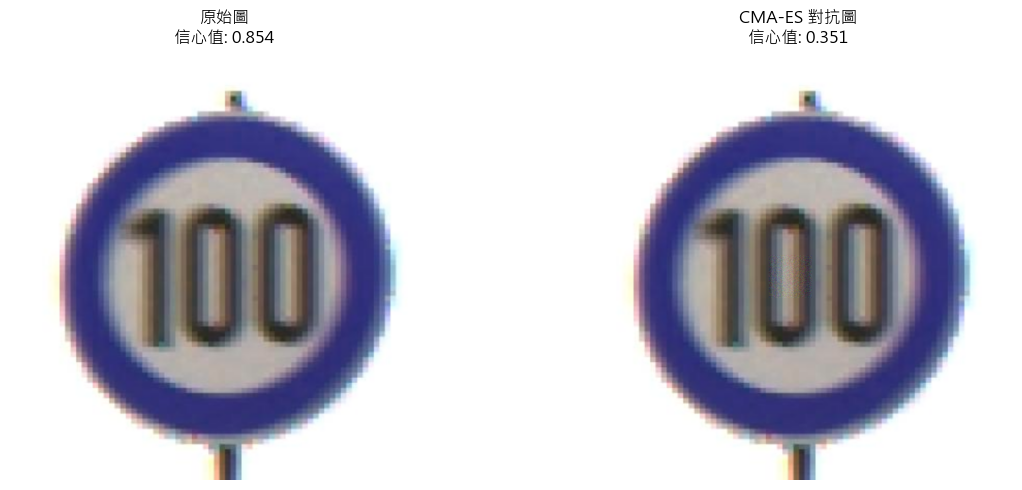

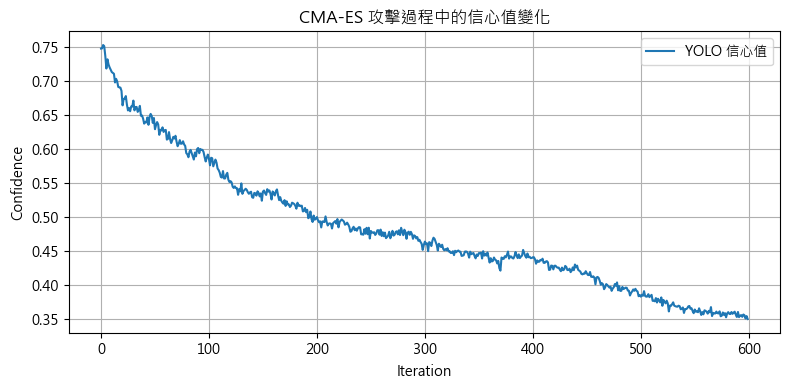

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cma

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 支援中文

# ======================== 基本參數 ========================
image_path = r"D:\Code\anaconda\code\adverserial_attack\archive\car\train\images\00007_00002_00023_png.rf.be3229e4dac05e06e9727e01f7761c4f.jpg"
model_path = r"D:\Code\anaconda\code\adverserial_attack\runs\detect\train4\weights\best.pt"

patch_size = 64
max_iter = 700
epsilon = 0.04
popsize = 20
target_cls = None           # 可設目標類別，或設為 None
early_stop_threshold = 0.2  # 信心值門檻，低於此值提前停止

# ======================== 載入模型與圖片 ========================
yolo_model = YOLO(model_path).to('cuda')
orig_img = cv2.imread(image_path)
orig_img = cv2.resize(orig_img, (640, 640)).astype(np.float32) / 255.0

def get_yolo_score(img_np):
    x_tensor = torch.tensor(img_np.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = yolo_model(x_tensor)
    boxes = results[0].boxes
    if len(boxes) == 0:
        return 0.0
    if target_cls is not None:
        boxes = boxes[boxes.cls == target_cls]
        if len(boxes) == 0:
            return 0.0
    return float(boxes.conf.max().item())

original_score = get_yolo_score(orig_img)
print(f"原始圖片信心值: {original_score:.4f}")

# ======================== CMA-ES 攻擊主函數 ========================
def cmaes_patch_attack(image, yolo_model, patch_size=64, max_iter=100, epsilon=0.7, target_cls=None, popsize=20, stop_score=0.2):
    h, w, _ = image.shape
    img = image.copy()

    # ==== 取得初始框位置 ====
    x_tensor = torch.tensor(img.transpose(2, 0, 1)).float().unsqueeze(0).to('cuda')
    with torch.no_grad():
        results = yolo_model(x_tensor)
    boxes = results[0].boxes

    if len(boxes) == 0:
        print("⚠️ 未偵測到任何框，隨機放置 patch")
        top = np.random.randint(0, h - patch_size)
        left = np.random.randint(0, w - patch_size)
    else:
        target_boxes = boxes[boxes.cls == target_cls] if target_cls is not None else boxes
        if len(target_boxes) == 0:
            target_boxes = boxes
        box = target_boxes[torch.argmax(target_boxes.conf)]
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        top = max(0, min(h - patch_size, cy - patch_size // 2))
        left = max(0, min(w - patch_size, cx - patch_size // 2))

    init_patch = np.zeros((patch_size * patch_size * 3), dtype=np.float32)
    confidence_history = []

    def evaluate(patch_flat):
        patch = patch_flat.reshape((patch_size, patch_size, 3))
        patch = np.clip(patch, -epsilon, epsilon)

        adv_img = img.copy()
        adv_img[top:top+patch_size, left:left+patch_size] += patch
        adv_img = np.clip(adv_img, 0, 1)

        score = get_yolo_score(adv_img)
        return score

    es = cma.CMAEvolutionStrategy(init_patch, 0.2, {'maxiter': max_iter, 'popsize': popsize})
    while not es.stop():
        solutions = es.ask()
        scores = [evaluate(np.array(x)) for x in solutions]
        es.tell(solutions, scores)

        best_score = min(scores)
        confidence_history.append(best_score)
        print(f"[Iteration {len(confidence_history)}] 最佳信心值: {best_score:.4f}")

        if best_score < stop_score:
            print(f"✅ 提前停止，信心值低於 {stop_score}")
            break

        es.disp()

    best_patch = es.best.x.reshape((patch_size, patch_size, 3))
    best_patch = np.clip(best_patch, -epsilon, epsilon)

    adv_img = img.copy()
    adv_img[top:top+patch_size, left:left+patch_size] += best_patch
    adv_img = np.clip(adv_img, 0, 1)

    return adv_img, (top, left, patch_size), best_patch, confidence_history

# ========== 執行攻擊 ==========
adv_img, (t, l, s), best_patch, confidence_history = cmaes_patch_attack(
    orig_img, yolo_model=yolo_model,
    patch_size=patch_size,
    max_iter=max_iter,
    epsilon=epsilon,
    target_cls=target_cls,
    popsize=popsize,
    stop_score=early_stop_threshold
)

adv_score = get_yolo_score(adv_img)
print(f"最終對抗圖片信心值: {adv_score:.4f}")

# ========== 顯示圖片 ==========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"原始圖\n信心值: {original_score:.3f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"CMA-ES 對抗圖\n信心值: {adv_score:.3f}")
plt.axis('off')
plt.tight_layout()
plt.show()

# ========== 儲存圖片 ==========
adv_img_uint8 = (adv_img * 255).astype(np.uint8)
cv2.imwrite("cmaes_adv_result1.png", cv2.cvtColor(adv_img_uint8, cv2.COLOR_RGB2BGR))

# Patch 圖
patch_img = (best_patch + epsilon) / (2 * epsilon)  # Normalize to [0, 1]
cv2.imwrite("patch.png", (patch_img * 255).astype(np.uint8))

# 差異圖
diff_img = np.abs(orig_img - adv_img)
cv2.imwrite("diff.png", (diff_img * 255).astype(np.uint8))

# ========== 畫出信心值下降歷程 ==========
plt.figure(figsize=(8, 4))
plt.plot(confidence_history, label="YOLO 信心值")
plt.xlabel("Iteration")
plt.ylabel("Confidence")
plt.title("CMA-ES 攻擊過程中的信心值變化")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("score_plot.png")
plt.show()


In [ ]:
# ========== 可視化對比 ==========

labels = ['Original', 'NES', 'CMA-ES', 'Boundary']
scores = [
    get_yolo_score(img),
    get_yolo_score(nes_img),
   # get_yolo_score(adv_img),
   # get_yolo_score(adv_boundary)
]

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=['green', 'orange', 'blue', 'red'])
plt.ylabel("YOLO Max Confidence")
plt.title("對 YOLO 的黑箱攻擊比較")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/score_comparison.png")
plt.show()